In [401]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import os

from dataclasses import dataclass

from pyspark.sql import Column as PysparkColumn
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window

from typing import List
from typing import NamedTuple
from typing import Union
from typing import Tuple
from typing import Optional

spark = SparkSession.builder.getOrCreate() 
#consider replace this to your own spark cluster session instead of using local

plt.style.use('seaborn')

In [402]:
# some utils functions in order to load the data

def read_csv(path: str) -> DataFrame:
    '''loads csv data infering the schema'''
    
    return (
        spark.read.format("com.databricks.spark.csv") 
        .option("header", "true")
        .option("treatEmptyValuesAsNulls", "true")
        .option("inferSchema", "true")
        .load(f"Tables/{path}")        
    )


def create_catalog(tables: List) -> None:
    '''creates a local spark-warehouse'''
    
    for table in tables:
        _df = read_csv(table)
        _df.createOrReplaceTempView(table)
        
        
def read_json_from_file(file_path: str) -> List:
    '''reads the raw json'''
    
    with open(file_path, 'r') as f:
        json_data = f.read()
        data = json.loads(json_data)
    return data


def write_json_to_file(data: List[str], file_path) -> None:
    '''write the json back as one object per line'''
    
    with open(file_path, 'w') as file:
        for item in data:
            json.dump(item, file)
            file.write('\n')

            
def read_json_output(output_file: str, schema: str) -> DataFrame:
    '''reads the processed json on spark'''
    
    return spark.read.schema(schema).json(output_file)


def unnest_json_df(df: DataFrame) -> DataFrame:
    '''unnest the raw data into columns'''
    
    return (
        df.select("account_id", F.explode("transactions").alias("transaction"))
        .select(
            F.col("transaction.transaction_id").cast('long').alias("id"),
            F.col("account_id").cast('long').alias("account_id"),
            F.col("transaction.amount").cast('double').alias("amount"),
            F.col("transaction.investment_requested_at").cast('int').alias("investment_requested_at"),
            F.col("transaction.investment_completed_at").cast('string').alias("investment_completed_at"),
            F.col("transaction.status").cast('string').alias("status"),
            F.col("transaction.type").cast('string').alias("type"),
        )
    )


def create_investments_df() -> None:
    '''data pipeline that consumes the raw json and write it in the catalog'''
    
    input_file_path = 'Tables/investments/investments_json.txt'
    output_file_path = 'Tables/investments/investments.json'
    
    schema = """
        account_id STRING,
        transactions ARRAY<STRUCT<
            transaction_id: STRING,
            status: STRING,
            amount: STRING,
            investment_requested_at: STRING,
            investment_completed_at: STRING,
            investment_completed_at_timestamp: DATE,
            type: STRING
        >>
    """
    
    json_data = read_json_from_file(input_file_path)
    write_json_to_file(json_data, output_file_path)
    
    json_df = read_json_output(output_file_path,schema)
    unnested_df = unnest_json_df(json_df)
    
    return unnested_df.createOrReplaceTempView("investments")


In [403]:
create_catalog(os.listdir("Tables/"))
create_investments_df()

# Problem Statement 1:
Your colleague Jane Hopper, the Business Analyst in charge of analyzing customer behavior, who directly
consumes data from the Data Warehouse Environment, needs to get all the account's monthly balances between
Jan/2020 and Dec/2020. She wasn't able to do it alone, and asked for your help. Add to your solution the SQL
query (.sql file) used to retrieve the data needed (the necessary tables were sent in csv format along with this pdf,
on folder tables/). Feel free to use the dialect of your choice, but please specify the SQL engine.

In [404]:
TOTAL_TRANSFER_IN = "SUM(CASE WHEN in_or_out LIKE '%in%' THEN amount ELSE 0 END)"
TOTAL_TRANSFER_OUT = "SUM(CASE WHEN in_or_out LIKE '%out%' THEN amount ELSE 0 END)"

df_account_monthly_balance = spark.sql(f"""

WITH

raw_data AS (
-- Gets raw data from both pix and non-pix transactions

    SELECT *, "transfer_in" AS in_or_out, "non_pix" AS type
    FROM transfer_ins

    UNION ALL

    SELECT *, "transfer_out" AS in_or_out, "non_pix" AS type
    FROM transfer_outs

    UNION ALL

    SELECT *, "pix" AS type
    FROM pix_movements
    
),

report AS (
-- Gets 2020's Account Monthly Balance for Pix 

    SELECT
        month(from_unixtime(transaction_requested_at)) AS Month,
        account_id                                     AS Customer,
        {TOTAL_TRANSFER_IN}                            AS TotalTransferIn,
        {TOTAL_TRANSFER_OUT}                           AS TotalTransferOut,
        {TOTAL_TRANSFER_IN} - {TOTAL_TRANSFER_OUT}     AS AccountMonthlyBalance    

    FROM raw_data
   WHERE from_unixtime(transaction_requested_at) >= "2020-01-01"
     AND from_unixtime(transaction_requested_at) <  "2021-01-01"
     AND status = "completed"
    GROUP BY 1,2
    
)

SELECT *
FROM report

"""
)

df_account_monthly_balance.show()

+-----+-------------------+------------------+------------------+---------------------+
|Month|           Customer|   TotalTransferIn|  TotalTransferOut|AccountMonthlyBalance|
+-----+-------------------+------------------+------------------+---------------------+
|    2|1702680208601907456|            529.89|           1602.84|  -1072.9499999999998|
|    3|2001021613139299072|           1277.98|               0.0|              1277.98|
|    7|1322455016220591104|            398.61|               0.0|               398.61|
|    5|2896138879195125248|           5409.79|           1216.93|              4192.86|
|   11|1816947191131784704|            869.98|               0.0|               869.98|
|    6|3223316904186844160|1431.4599999999998|               0.0|   1431.4599999999998|
|   11| 707647286167164416|           1915.25|               0.0|              1915.25|
|   12| 486526423505004160|           1637.25|               0.0|              1637.25|
|   12|2304710428148083712|     

# Problem Statement 2:
Data model modification proposal with a visual representation and trade-off analysis

In [405]:
@dataclass
class ProductDailyEvents:
    """
    
    This class sits between our original source tables and the reporting enviroment. It
    transforms data from service tables into a standardized table that will help us to
    create more flexible and scalable datamarts
    
    """
    
    table: DataFrame
    account_id_col: str
    amount_col: str
    requested_at_col: str
    completed_at_col: str
    status_col: str
    in_or_out_col: str
    product: str
        
    accounts: DataFrame = spark.table("accounts").select("account_id","customer_id")
    customers: DataFrame = spark.table("customers").select("country_name","customer_id")
        
    def get_transformed_table(self) -> DataFrame:
        return (
            self.table
            .select(
                F.col(self.account_id_col).alias("account_id"),
                F.col(self.amount_col).alias("amount"),
                F.col(self.requested_at_col).alias("txn_requested_at"),
                F.col(self.completed_at_col).alias("txn_completed_at"),
                F.col(self.status_col).alias("status"),
                F.when(
                    F.col(self.in_or_out_col).like("%_in%"),F.lit("in")
                ).otherwise(F.lit("out")).alias("in_or_out"),
                F.lit(self.product).alias("product"),
            )
            .join(self.accounts, on="account_id", how="left")
            .join(self.customers, on="customer_id", how="left")
            .withColumn("day",F.dayofmonth(F.from_unixtime("txn_requested_at")))
            .withColumn("month",F.month(F.from_unixtime("txn_requested_at")))
            .withColumn("event_date",F.date_format(F.from_unixtime("txn_requested_at"),"yyyy-MM-dd"))
            .drop("customer_id")
        )
    
    def write_in_spark_warehouse(self,mode) -> None:
        df = self.get_transformed_table()
        df.write.mode(mode).format("parquet").saveAsTable("products_daily_events")

In [406]:
pix_movements = spark.table("pix_movements")
transfer_ins = spark.table("transfer_ins").withColumn("in_or_out", F.lit("non_pix_in"))
transfer_outs = spark.table("transfer_outs").withColumn("in_or_out", F.lit("non_pix_out"))
investments = spark.table("investments")

daily_events_pix = ProductDailyEvents(
    table=pix_movements,
    account_id_col="account_id",
    amount_col="pix_amount",
    requested_at_col="pix_requested_at",
    completed_at_col="pix_completed_at",
    status_col="status",
    in_or_out_col="in_or_out",
    product="pix"
)
daily_events_pix.write_in_spark_warehouse(mode="overwrite")

daily_events_transfer_in = ProductDailyEvents(
    table=transfer_ins,
    account_id_col="account_id",
    amount_col="amount",
    requested_at_col="transaction_requested_at",
    completed_at_col="transaction_completed_at",
    status_col="status",
    in_or_out_col="in_or_out",
    product="non_pix",
)
daily_events_transfer_in.write_in_spark_warehouse(mode="append")

daily_events_transfer_out = ProductDailyEvents(
    table=transfer_outs,
    account_id_col="account_id",
    amount_col="amount",
    requested_at_col="transaction_requested_at",
    completed_at_col="transaction_completed_at",
    status_col="status",
    in_or_out_col="in_or_out",
    product="non_pix",
)
daily_events_transfer_out.write_in_spark_warehouse(mode="append")

daily_events_investments = ProductDailyEvents(
    table=investments,
    account_id_col="account_id",
    amount_col="amount",
    requested_at_col="investment_requested_at",
    completed_at_col="investment_completed_at",
    status_col="status",
    in_or_out_col="type",
    product="investments",
)
daily_events_investments.write_in_spark_warehouse(mode="append")

In [407]:
spark.table("products_daily_events").show()

+-------------------+-------+----------------+----------------+---------+---------+-------+------------+---+-----+----------+
|         account_id| amount|txn_requested_at|txn_completed_at|   status|in_or_out|product|country_name|day|month|event_date|
+-------------------+-------+----------------+----------------+---------+---------+-------+------------+---+-----+----------+
| 438980267812145600|1396.64|      1579074367|            None|   failed|      out|non_pix|      Brasil| 15|    1|2020-01-15|
| 253931865368420288|1684.49|      1595144491|      1595144500|completed|      out|non_pix|      Brasil| 19|    7|2020-07-19|
|1410463889223333888| 357.91|      1580605502|      1580605515|completed|      out|non_pix|      Brasil|  1|    2|2020-02-01|
| 967032139408421376|1933.77|      1580938498|      1580938517|completed|      out|non_pix|      Brasil|  5|    2|2020-02-05|
| 479529564765572288|  348.9|      1578923002|      1578923007|completed|      out|non_pix|      Brasil| 13|    1|2020

# Problem Statement 3:
Migration plan and strategy in order to implement the data model modification
proposal mentioned above

# Problem Statement 4:
On another note, Jane's friend, Pepino, wants to know how well our PIX product is doing inside Nubank. For that,
he wants your help to come up with indicators that can be used to track the technical and business performance of
the product. Which metrics would you suggest to track and why?

In [408]:
class CustomDimensions(NamedTuple):
    """
    Defines all custom dimensions that can be add to the 'products_daily_events' table in
    order to create our businness metrics.
    """
    
    WINDOW_ACCOUNT = (
        Window()
        .partitionBy("account_id")
        .orderBy(F.col("txn_requested_at"))
    )
    
    WINDOW_ACCOUNT_24H = (
        Window()
        .partitionBy("account_id")
        .orderBy(F.col("txn_requested_at").cast("long"))
        .rangeBetween(-24, Window.currentRow)
    )
    
    WINDOW_ACCOUNT_EVER = (
        Window()
        .partitionBy("account_id")
        .orderBy(F.col("txn_requested_at"))
        .rangeBetween(Window.unboundedPreceding, Window.currentRow)
    )
    
    TXN_REQUESTED_AT_TS = (
        F.from_unixtime("txn_requested_at")
    ).alias("txn_requested_at_ts")
    
    TXN_COMPLETED_AT_TS = (
        F.from_unixtime("txn_completed_at")
    ).alias("txn_completed_at_ts")
    
    TIME_TO_COMPLETE_IN_SECONDS = (
        F.col("txn_completed_at").cast("long")-F.col("txn_requested_at").cast("long")
    ).alias("time_to_complete_in_seconds")
    
    COUNT_TXNS_PER_ACCOUNT_EVER = (
        F.sum(F.lit(1)).over(WINDOW_ACCOUNT_EVER)
    ).alias("count_txns_orders_per_account_ever")
    
    LAST_TXN_DATE = (
        F.lag("txn_requested_at",1).over(WINDOW_ACCOUNT)
    ).alias("last_txn_date")
    
    TIME_FROM_LAST_TXN_IN_DAYS = (
        ((F.col("txn_completed_at").cast("long")-LAST_TXN_DATE.cast("long"))/86400)
    ).alias("time_from_last_txn_in_days")
    
    @classmethod
    def get_all(cls) -> List[F.Column]:
        """ 
        The get_all() class method is an option to generate all at once in a single list 
        """
        return [
            cls.TXN_REQUESTED_AT_TS,
            cls.TXN_COMPLETED_AT_TS,
            cls.TIME_TO_COMPLETE_IN_SECONDS,
            cls.COUNT_TXNS_PER_ACCOUNT_EVER,
            cls.LAST_TXN_DATE,
            cls.TIME_FROM_LAST_TXN_IN_DAYS,
        ]

In [409]:
class Metrics(NamedTuple):
    """
    Defines all logics and businnes rules for our metrics.
    """
    
    FAILED = (F.col("status")=="failed")
    
    COMPLETED = (F.col("status")=="completed")
    
    FIRST_TXN = (F.col("count_txns_orders_per_account_ever")==1)
    
    TOTAL_AMOUNT = F.sum(F.col("amount")).alias("total_amount")
    
    TOTAL_AMOUNT_COMPLETED = (
        F.sum(F.when(COMPLETED,F.col("amount")).otherwise(0))
    ).alias("total_amount_completed")
    
    TOTAL_AMOUNT_FAILED = (
        F.sum(F.when(FAILED,F.col("amount")).otherwise(0))
    ).alias("total_amount_failed")
    
    TOTAL_TRANSFER_IN = (
        F.sum(F.when(F.col("in_or_out")=="in",F.col("amount")).otherwise(0))
    ).alias("total_transfer_in")

    TOTAL_TRANSFER_OUT = (
        F.sum(F.when(F.col("in_or_out")=="out",F.col("amount")).otherwise(0))
    ).alias("total_transfer_out")
    
    ACCOUNT_MONTHLY_BALANCE =  (
        TOTAL_TRANSFER_IN - TOTAL_TRANSFER_OUT
    ).alias("account_monthly_balance")
    
    FAIL_RATE = F.round(
        TOTAL_AMOUNT_FAILED / TOTAL_AMOUNT_COMPLETED, 2
    ).alias("fail_rate")
    
    COMPLETED_RATE = F.round(
        TOTAL_AMOUNT_COMPLETED / TOTAL_AMOUNT, 2
    ).alias("completed_rate")
    
    AVG_TIME_TO_COMPLETED = (
        F.avg(F.col("time_to_complete_in_seconds"))
    ).alias("avg_time_to_completed") 
    
    AVG_RECENCY = (
        F.avg(F.col("time_from_last_txn_in_days"))
    ).alias("avg_recency")
    
    TOTAL_ORDERS = (
        F.sum(F.lit(1))
    ).alias("total_orders")
    
    TOTAL_FIRST_TXN_ORDERS = (
        F.sum(F.when(FIRST_TXN,F.lit(1)).otherwise(0))
    ).alias("total_first_txn_orders")
    
    ATV = (
        F.avg(F.col("amount"))
    ).alias("atv")
    
    P99_TIME_TO_COMPLETED = (
        F.percentile_approx("time_to_complete_in_seconds", 0.99).alias("p99")
    )
    
    P90_TIME_TO_COMPLETED = (
        F.percentile_approx("time_to_complete_in_seconds", 0.90).alias("p90")
    )
    
    @classmethod
    def get_all(cls) -> List[PysparkColumn]:
        """ 
        The get_all() class method is an option to generate all at once in a single list 
        """
        return [
            cls.TOTAL_AMOUNT,
            cls.TOTAL_AMOUNT_COMPLETED,
            cls.TOTAL_AMOUNT_FAILED,
            cls.FAIL_RATE,
            cls.COMPLETED_RATE,
            cls.AVG_TIME_TO_COMPLETED,
            cls.AVG_RECENCY,
            cls.TOTAL_ORDERS,
            cls.TOTAL_FIRST_PIX_ORDERS,
            cls.ATV,
            cls.P99_TIME_TO_COMPLETED,
            cls.P90_TIME_TO_COMPLETED,
        ]

In [413]:
def get_monthly_metrics_plot(
    df: DataFrame,
    metric: List[PysparkColumn],
    title: str, 
) -> None:
    """
    Auxiliar function to help plot the monthly metrics
    """
    
    return (df
            .groupBy("event_date")
            .agg(*metric)
            .sort(F.asc("event_date"))
            .toPandas()
            .plot
            .line(x="event_date", title=title)
            .legend(loc='center left', bbox_to_anchor=(1, 0.5))
           )

In [414]:
df_viz = (spark.table("products_daily_events")
          .where(F.col("product")=="pix")
          .select("*", *CustomDimensions.get_all()))

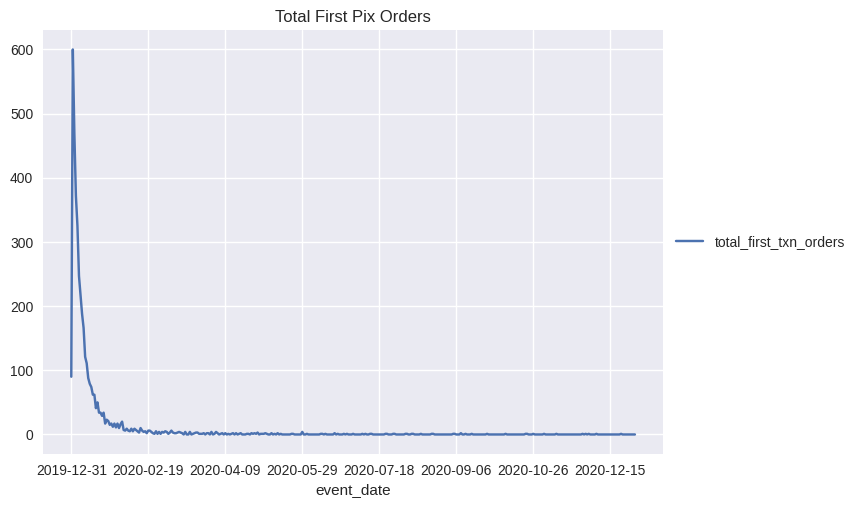

In [415]:
get_monthly_metrics_plot(df_viz,[Metrics.TOTAL_FIRST_TXN_ORDERS],"Total First Pix Orders")

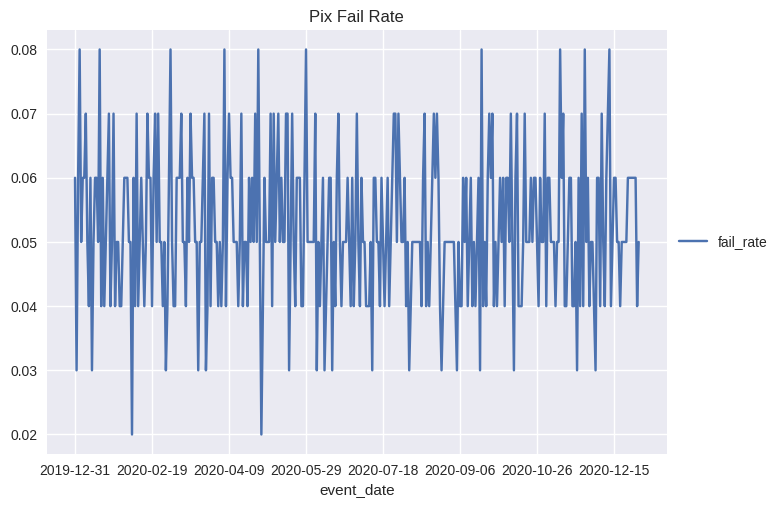

In [416]:
get_monthly_metrics_plot(df_viz,[Metrics.FAIL_RATE],"Pix Fail Rate")

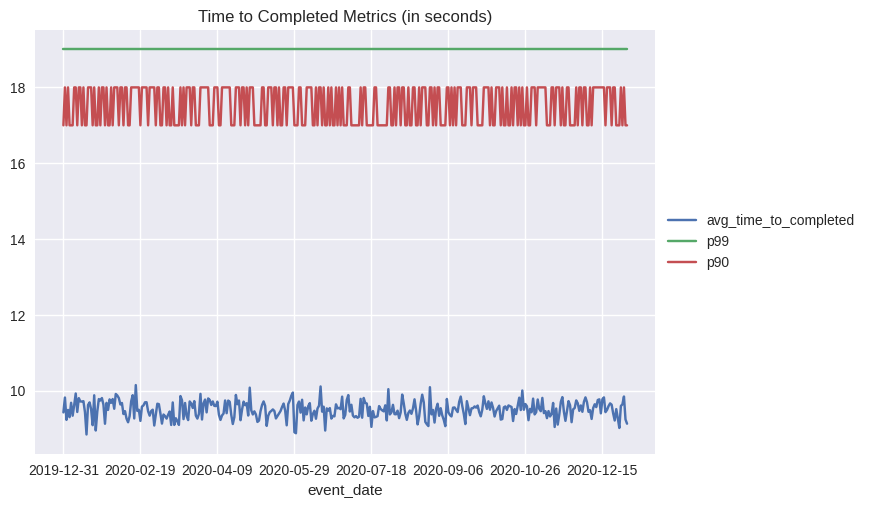

In [417]:
metrics = [
     Metrics.AVG_TIME_TO_COMPLETED,
     Metrics.P99_TIME_TO_COMPLETED,
     Metrics.P90_TIME_TO_COMPLETED,
]

get_monthly_metrics_plot(df_viz,metrics,"Time to Completed Metrics (in seconds)")

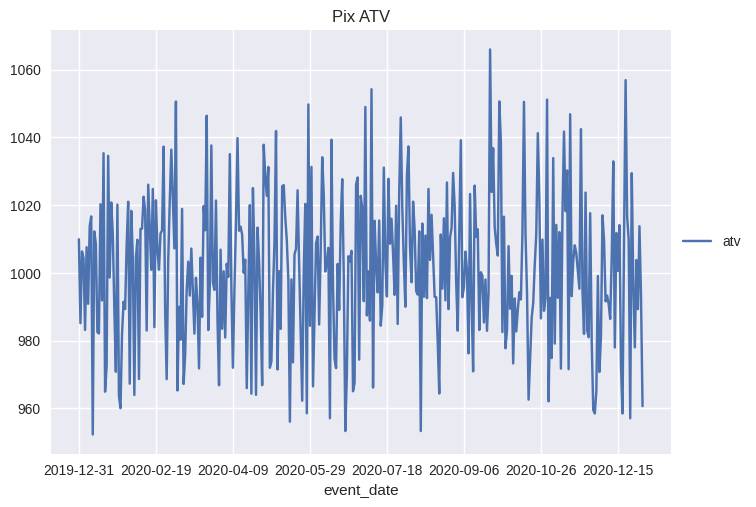

In [418]:
get_monthly_metrics_plot(df_viz,[Metrics.ATV],"Pix ATV")

# Problem Statement 5:
Another business analyst, Sophia, would like your help to analyze how much money Nubank's customers' have on their investment account on a daily basis.

In [428]:
class InvestmentsMetrics(NamedTuple):
    """
    Defines all logics, businnes rules and constants for our investments metrics
    """
    
    INVESTMENTS_LAG_WINDOW = (
        Window()
        .partitionBy("account_id")
        .orderBy(F.col("event_date"))
    )

    INVESTMENTS_CUM_WINDOW = (
        Window()
        .partitionBy("account_id")
        .orderBy(F.col("event_date"))
        .rowsBetween(Window.unboundedPreceding,Window.currentRow)
    )

    FIXED_RATE = 0.0001

    TOTAL_DEPOSIT = (
        F.sum(F.when(F.col("in_or_out")=="in",F.col("amount")).otherwise(0))
    ).alias("deposit")

    TOTAL_WITHDRAWAL = (
        F.sum(F.when(F.col("in_or_out")=="out",F.col("amount")).otherwise(0))
    ).alias("withdrawal")

    TOTAL_BALANCE = (
        TOTAL_DEPOSIT-TOTAL_WITHDRAWAL
    ).alias("balance")

    PREVIOUS_DAY_TOTAL_BALANCE = (
        F.lag(TOTAL_BALANCE,default=0).over(INVESTMENTS_LAG_WINDOW)
    ).alias("previous_day_balance")

    TOTAL_MOVEMENTS = (
        F.sum(TOTAL_BALANCE).over(INVESTMENTS_CUM_WINDOW)
    ).alias("movements")

    _END_OF_DAY_INCOME = (
        TOTAL_MOVEMENTS*F.lit(FIXED_RATE)
    ).alias("_end_of_day_income")
    
    END_OF_DAY_INCOME = (
        F.when(_END_OF_DAY_INCOME<0,F.lit(0)).otherwise(_END_OF_DAY_INCOME)
    ).alias("end_of_day_income")

    ACCOUNT_DAILY_BALANCE = (
        TOTAL_MOVEMENTS+END_OF_DAY_INCOME
    ).alias("account_daily_balance")
    
    @classmethod
    def get_all(cls) -> List[PysparkColumn]:
        """ 
        The get_all() class method is an option to generate all at once in a single list 
        """
        return [
            cls.TOTAL_DEPOSIT,
            cls.TOTAL_WITHDRAWAL,
            cls.TOTAL_BALANCE,
            cls.PREVIOUS_DAY_TOTAL_BALANCE,
            cls.TOTAL_MOVEMENTS,
            cls.END_OF_DAY_INCOME,
            cls.ACCOUNT_DAILY_BALANCE,
        ]    

In [430]:
def create_investments_daily_balance_df(
    df: DataFrame,
    interval: Tuple[str,str],
    metrics: InvestmentsMetrics = InvestmentsMetrics(),
) -> DataFrame:
    ''' Creates the Investments Daily Balance Report '''
    
    return (
        df
        .where(F.col("event_date").between(*interval))
        .where(F.col("status")=="completed")
        .where(F.col("product")=="investments")
        .groupBy("event_date","day","month","account_id")
        .agg(*metrics.get_all())
        .drop("event_date","balance","previous_day_balance","movements")
    )

def create_account_monthly_balance(
    df: DataFrame, 
    interval: Tuple[str,str],
    products: List[str],
    metrics: Metrics = Metrics(),
) -> DataFrame:
    ''' Creates the Account Monthly Balance Report '''
    
    return (
        df
        .where(F.col("event_date").between(*interval))
        .where(F.col("status")=="completed")
        .where(F.col("product").isin(products))
        .groupBy("month","account_id")
        .agg(metrics.TOTAL_TRANSFER_IN,
             metrics.TOTAL_TRANSFER_OUT,
             metrics.ACCOUNT_MONTHLY_BALANCE,
            )
    )    

In [435]:
df_products_daily_events = spark.table("products_daily_events")

create_investments_daily_balance_df(
    df=df_products_daily_events,
    interval=["2020-01-01","2021-01-01"],
).show()

+---+-----+----------------+-------+----------+--------------------+---------------------+
|day|month|      account_id|deposit|withdrawal|   end_of_day_income|account_daily_balance|
+---+-----+----------------+-------+----------+--------------------+---------------------+
| 19|    1| 623509224135263|  859.8|       0.0|             0.08598|    859.8859799999999|
|  4|    2| 623509224135263| 514.33|       0.0|            0.137413|          1374.267413|
| 25|    2| 623509224135263|1463.14|       0.0| 0.28372700000000006|   2837.5537270000004|
|  5|    4| 623509224135263| 806.43|       0.0|             0.36437|           3644.06437|
|  3|    6| 623509224135263| 876.47|       0.0|            0.452017|          4520.622017|
| 16|    6| 623509224135263| 261.75|       0.0|            0.478192|          4782.398192|
| 17|    6| 623509224135263| 528.28|       0.0|             0.53102|           5310.73102|
| 22|    9| 623509224135263| 499.66|       0.0|            0.580986|          5810.440986|

In [424]:
create_account_monthly_balance(
    df=df_products_daily_events,
    interval=["2020-01-01","2021-01-01"],
    products=["non_pix","pix"]
).show()

+-----+-------------------+------------------+------------------+-----------------------+
|month|         account_id| total_transfer_in|total_transfer_out|account_monthly_balance|
+-----+-------------------+------------------+------------------+-----------------------+
|    1|1327771564818299392|            2971.8|            523.68|     2448.1200000000003|
|    2|1327771564818299392|            638.89|            418.03|                 220.86|
|    3|1327771564818299392|            3164.4|            515.74|                2648.66|
|    4|1327771564818299392|10643.779999999999|3046.6499999999996|      7597.129999999999|
|    5|1327771564818299392|           2355.33|            4000.8|    -1645.4700000000003|
|    6|1327771564818299392|2364.0699999999997|           1486.54|      877.5299999999997|
|    7|1327771564818299392| 943.9799999999999|               0.0|      943.9799999999999|
|    8|1327771564818299392|2495.1000000000004|            403.86|     2091.2400000000002|
|    9|132